In [1]:
import urllib.request, json 
import pickle
import pandas as pd
import numpy as np
import re

In [2]:
def get_json(_url):
    with urllib.request.urlopen(_url) as url:
        data = json.loads(url.read().decode())
        return data

In [3]:
def get_votes(_afstemnings_id):
    a = get_json("https://oda.ft.dk/api/Afstemning("+str(_afstemnings_id)+")/Stemme?$inlinecount=allpages")
    if a["odata.nextLink"]:
        b = get_json(a["odata.nextLink"])
        for stemme in b["value"]:
            a["value"].append(stemme)
    return a

In [4]:
def get_actor(_actor_id):
    data = get_json("https://oda.ft.dk/api/Akt%C3%B8r("+str(_actor_id)+")")
    name = data["navn"]
    biografi = data["biografi"]
    party = None
    if not(biografi is None):
        res = re.findall("<party>(.*)<\/party>", biografi)
        if(len(res) > 0):
            party = res[0]
    return {"name": name, "party": party}    

In [5]:
afstemninger = {}
actors = {}

In [6]:
def get_cleaned_votes(_afstemning):
    if _afstemning in afstemninger:
        return afstemninger[_afstemning]
    votes = ["for", "imod", "fraværende"]
    ugly_votes = get_votes(_afstemning)
    cleaned_votes = []
    for stemme in ugly_votes["value"]:
        aktørid = stemme["aktørid"]
        if not(aktørid in actors):
            actors[aktørid] = get_actor(aktørid)
        cleaned_votes.append({"vote": stemme["typeid"], "actor": actors[aktørid]["name"]})
    return cleaned_votes

In [7]:
def load_data_day(year, month, day):
    long_url = "https://oda.ft.dk/api/Afstemning?$inlinecount=allpages&$filter=year(opdateringsdato)%20eq%20"+str(year) + "%20and%20month(opdateringsdato)%20eq%20"+str(month)+"%20and%20day(opdateringsdato)%20eq%20"+str(day)
    votes_today = get_json(long_url)
    
    for afstemning in votes_today["value"]:
        afstemnings_id = afstemning["id"]
        if afstemnings_id in afstemninger:
            continue
        afstemninger[afstemnings_id] = {"votes": get_cleaned_votes(afstemnings_id), "nummer": afstemning["nummer"]}

In [8]:
def load_data():
    for month in range(1, 6):
        print(".", end="")
        for day in range(1, 32):
            load_data_day(2019, month, day)

In [9]:
#load_data()

In [12]:
if True:
    df = pd.DataFrame(index=["name"], columns=["id", "party"])
    for a_id in actors:
        df.loc[actors[a_id]["name"]] = [a_id, actors[a_id]["party"]]

    for a_id in afstemninger:
        print(".", end="")
        df[a_id] = 0
        for stemme in afstemninger[a_id]["votes"]:
            df.loc[stemme["actor"], a_id] = stemme["vote"]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Load

In [13]:
print(len(actors))
print(len(afstemninger))

486
1482


In [11]:
actors = pickle.load(open("actors.p", "rb"))
afstemninger = pickle.load(open("afstemninger.p", "rb"))
df = pickle.load(open("data_frame.p", "rb"))

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

### Save

In [341]:
pickle.dump(actors, open("actors.p", "wb"))
pickle.dump(afstemninger, open("afstemninger.p", "wb"))
pickle.dump(df, open("data_frame.p", "wb"))

# The fun begins
Remember that the votes can be one of 4:
1. Vote for
2. Vote against
3. Do not care
4. Not there

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [20]:
df_clean = df.dropna()

In [340]:
df_clean.loc["Pia Adelsteen"].value_counts()

1                   552
2                   276
3                   257
0                   200
4                   197
221                   1
Dansk Folkeparti      1
Name: Pia Adelsteen, dtype: int64

In [25]:
features = df_clean.columns[2:].values
X = df_clean.loc[:, features]
Y = df_clean.loc[:, "party"]

In [26]:
X = StandardScaler().fit_transform(X)

/home/lasse/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/lasse/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [27]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, index=df_clean.index, columns=["principal component 1", "principal component 2"])

In [87]:
parties = ['Dansk Folkeparti', 'Socialdemokratiet', 'Radikale Venstre', 'Venstre', 'Liberal Alliance', 'Socialistisk Folkeparti',
       'Det Konservative Folkeparti', 'Enhedslisten', 'Alternativet', None]
colors = ["red", "red", "purple", "blue", "blue", "red", "green", "red", "red", "black"]

In [88]:
kendte = ["Helle Thorning-Schmidt", "Per Stig Møller", "Søren Pape", "Eva Kjer Hansen", "Rasmus Jarlov", "Karsten Lauritzen", "Holger K. Nielsen", "Bertel Haarder", "Inger Støjberg", "Troels Lund Poulsen", "Mette Bock", "Trine Bramsen", "Jakob Ellemann-Jensen", "Christian Langballe", "Merete Riisager", "Zenia Stampe", "Martin Lidegaard", "Laura Lindahl", "Søren Gade", "Anders Stjernholm", "Claus Hjort Frederiksen", "Pia Kjærsgaard", "Nicolai Wammen", "Kristian Thulesen Dahl", "Lars Løkke Rasmussen", "Kristian Jensen", "Mogens Lykketoft", "Mette Frederiksen", "Henrik Sass Larsen", "Naser Khader", "Peter Skaarup", "Anders Samuelsen", "Christine Antorini", "Søren Pind", "Morten Østergaard", "Søren Espersen", "Simon Emil Ammitzbøll-Bille", "Uffe Elbæk", "Martin Henriksen", "Pia Olsen Dyhr", "Johanne Schmidt-Nielsen", "Sophie Løhde", "Joachim B. Olsen", "Esben Lunde Larsen", "Dan Jørgensen", "Mette Abildgaard", "Bjarne Corydon", "Brian Mikkelsen", "Pernille Skipper", "Margrethe Vestager", "Erik Lund"]

In [ ]:
finalDf = pd.concat([principalDf, df_clean[['party']]], axis = 1)

In [119]:
finalDf = finalDf[finalDf.index.isin(kendte)]

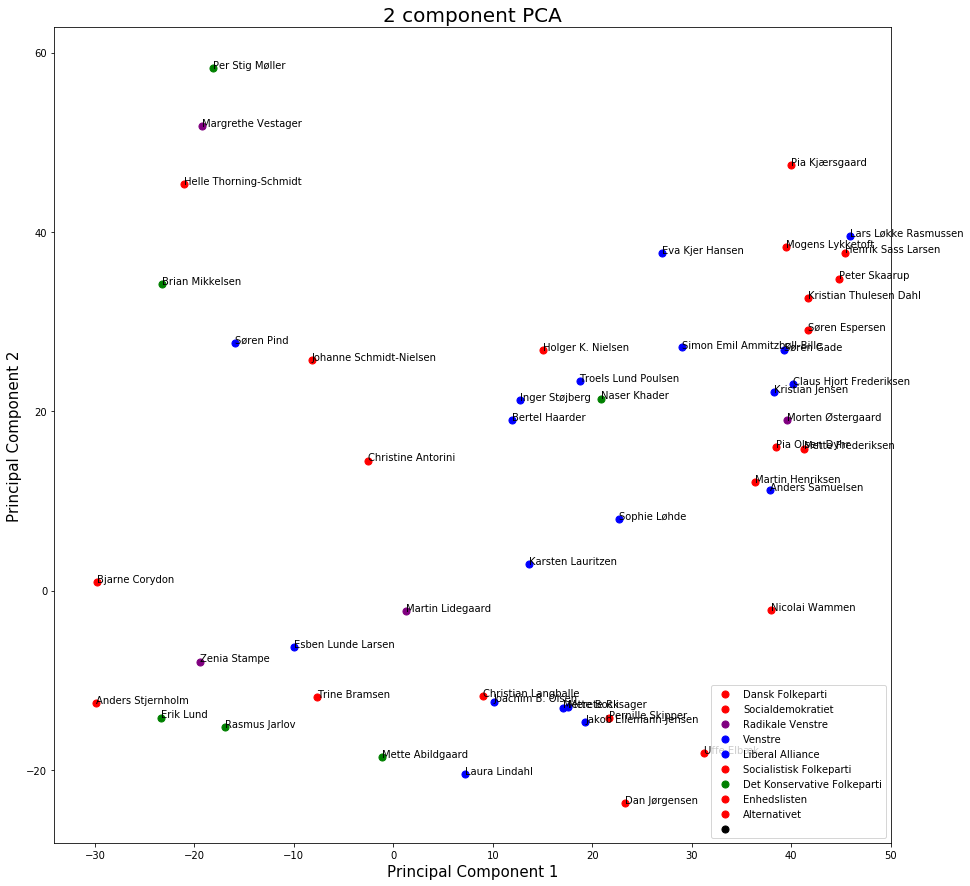

In [120]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = parties
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['party'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    ax.scatter(x, y, c = color, s = 50)

    for i, txt in enumerate(finalDf.loc[indicesToKeep].index):
        if txt in kendte:
            ax.annotate(txt, (x[i], y[i]))

ax.legend(targets)
plt.show()